# Unsupervised Clustering using Hidden Markov Model 

## Import packages

In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from hmmlearn import hmm
from simpl_eeg import (
    connectivity,
    eeg_objects,
    raw_voltage,
    topomap_2d,
    topomap_3d_brain,
    topomap_3d_head,
)

In [2]:
%matplotlib inline

## Introduction

Electroencephalograms (EEG) is an electrophysiological measurement method used to examine the electrical activity of the brain and represent it as location-based channels of waves and frequencies. Essentially, the EEG data from our dataset is recorded from 19 electrodes nodes for 1.5 hours. Therefore, the EEG data is in high dimensionality and could be represented as a multivariate time series data. If we present the data in a tabular format, the number of rows would be the time stamps and the number of columns would be the different electrodes. As we have 1.5 hrs experiment data and each seconds is recorded at 2048 Hz, which means we have 2048 EEG data readings per second, our dataset is large with at least 1 million rows.

## Objectives

EEG data is widely use in diagnosing brain disorders such as epilepsy and brain damage from head injuries, however, with the complexity of data and its dynamic changes over time, it is hard to identify any significant patterns by simply reading the data or visualizing it. The main objective of this strech goal is to find similar patterns from the combination of EEG signals of all 19 electrodes for a given time section from the dataset. In plain English, it is to cluster the brain states for different time periods in the data.

## Read in the Data

In [3]:
raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")

Reading C:\Users\Yiki\Documents\UBC\MDS\Homework\capstone\simpl_eeg_capstone\data\927\fixica.fdt


<ipython-input-3-99b5e4cf8c83>:1: RuntimeWarning: Data file name in EEG.data (927 fix ica correct.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")


In [5]:
entire_df = raw_full.to_data_frame()

In [6]:
channel_names=raw_full.ch_names

## Exploratory Data Analysis

In [7]:
entire_df.describe()

,time,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2
count,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07
mean,2.707150e+06,-4.951856e-02,-5.360361e-02,-1.970000e-01,-1.045423e-01,-1.890660e-01,-1.007904e-01,-1.226650e-01,-1.405565e-01,-5.769371e-02,-1.050824e-01,-1.218021e-01,-6.789351e-02,-7.151982e-02,-7.599173e-02,-7.250481e-02,-4.937661e-02,-3.070300e-02,-6.297736e-02,-5.717235e-02
std,1.562974e+06,7.881340e+00,7.769932e+00,1.212798e+01,6.043827e+00,1.199746e+01,1.222635e+01,1.163743e+01,1.126299e+01,1.231525e+01,1.199590e+01,1.220014e+01,1.141870e+01,1.149002e+01,1.256943e+01,6.294935e+00,6.381905e+00,1.206392e+01,1.185191e+01,1.647667e+01
min,0.000000e+00,-8.024929e+01,-7.839950e+01,-2.722647e+02,-8.675944e+01,-2.099264e+02,-1.635053e+02,-2.136972e+02,-3.073107e+02,-1.147499e+02,-1.185257e+02,-1.350610e+02,-1.872107e+02,-1.384043e+02,-1.338534e+02,-8.942552e+01,-9.223476e+01,-2.544708e+02,-3.976269e+02,-4.125500e+02
25%,1.353575e+06,-5.059593e+00,-4.970109e+00,-7.103350e+00,-3.798762e+00,-7.367568e+00,-7.708792e+00,-7.332805e+00,-7.187517e+00,-7.874664e+00,-7.798521e+00,-7.951976e+00,-7.010767e+00,-7.186753e+00,-7.971704e+00,-3.943664e+00,-4.024702e+00,-7.243095e+00,-6.864659e+00,-7.983721e+00
50%,2.707150e+06,-1.097212e-01,-8.891173e-02,-1.409743e-01,-1.799444e-01,-3.511483e-01,-1.710321e-01,-2.296336e-01,-2.677179e-01,-9.671074e-02,-2.464668e-01,-2.721145e-01,-8.589961e-02,-7.801341e-02,-1.233626e-01,-8.700962e-02,-6.181740e-02,-9.822004e-03,-1.093020e-01,-2.175741e-01
75%,4.060726e+06,4.897449e+00,4.826879e+00,6.797164e+00,3.490998e+00,6.722553e+00,7.428260e+00,6.991313e+00,6.756059e+00,7.727930e+00,7.434458e+00,7.546031e+00,6.851805e+00,7.061900e+00,7.780638e+00,3.782850e+00,3.918500e+00,7.192153e+00,6.669391e+00,7.602581e+00
max,5.414301e+06,8.276429e+01,8.739672e+01,2.333079e+02,9.022140e+01,1.838179e+02,2.396673e+02,2.372432e+02,1.325360e+02,1.173398e+02,1.020642e+02,1.369814e+02,2.460898e+02,1.723651e+02,1.609878e+02,8.442140e+01,7.311791e+01,2.648633e+02,4.283883e+02,5.051952e+02


<AxesSubplot:>

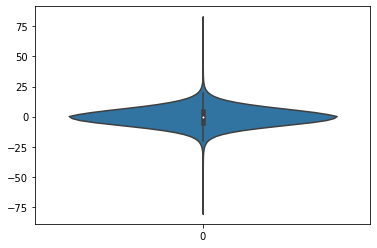

In [8]:
sns.violinplot(data=entire_df['Fp1'].values)

<AxesSubplot:>

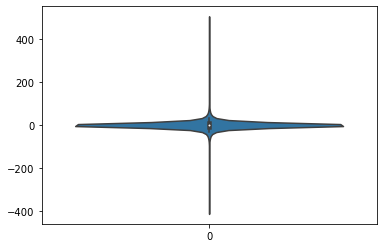

In [9]:
sns.violinplot(data=entire_df['O2'].values)

According to the EDA, the EEG data is following Gaussian distribution. However, there are clearly some outliers in the data. My next step is to remove the outliers of the data based on the expertise suggestions from the partner to keep EEG data which falls into (-50, 50) range.

## Data preprocessing

In [10]:
# drop rows where all values are zero
cleaned_df = entire_df.loc[(entire_df[channel_names] != 0).all(axis=1)]

# drop the outliers of dataset
df_no_outliers = cleaned_df.loc[((cleaned_df[channel_names] <=50) & (cleaned_df[channel_names] >= -50)).all(axis=1)]